In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from abc import ABCMeta, abstractmethod


DELTA = 1e-9
%matplotlib inline

# Байесовские бандиты (вплоть до 10 баллов)

#### дедлайн (жёсткий) задания: 14 мая, 23:59 UTC+3

#### при сдаче задания нужно послать в систему сдачи данный заполненный ноутбук с актуальной информацией о [ФИО] и [номер группы], в том числе в названии данного файла

# Работа выполнена: Владимиров Эдуард, М05-304а


В данной работе исследуется простая задача о многоруких бандитах с распределениями Бернулли и несколько стратегий её решения.

Бандиты имеют $K$ действий. Действие ведёт к награде $r=1$ с вероятностью $0 \le \theta_k \le 1$, неизвестной для агента, но фиксированной во времени. Цель агента состит в минимизации общей субоптимальности выполненных $T$ действий:

$$\rho = T\theta^* - \sum_{t=1}^T r_t,$$

и $\theta^* = \max_k\{\theta_k\}$.

**Пример из жизни** &mdash; клинические испытания: у нас есть $k$ видов лекарств и $T$ пациентов. После принятия лекарства пациент излечивается с вероятностью $\theta_k$. Цель состоит в поиске оптимального лекарства. Обзор по клиническим испытаниям &mdash; https://arxiv.org/pdf/1507.08025.pdf.

### Задание

Для того, чтобы получить максимальный балл, имплементируйте следующих агентов (будут указаны ниже):

1. [1 балл] $\varepsilon$-жадный алгоритм
2. [1 балл] UCB
3. [1 балл] сэмплирование по Томпсону
4. [2 балла] собственная стратегия
5. [2 балла] $\varepsilon$-жадный алгоритм для riverflow
6. [3 балла] PSRL агент для riverflow

In [10]:
SEED = 617 # Значение данной переменной не должно изменяться!


class BernoulliBandit:
    def __init__(self, n_actions=5):
        self._probs = np.random.random(n_actions)

    @property
    def action_count(self):
        return len(self._probs)

    def pull(self, action):
        if np.random.random() > self._probs[action]:
            return 0
        return 1

    def optimal_reward(self):
        """ Используется для вычисления регрета
        """
        return np.max(self._probs)

    def step(self):
        """ Используется в нестационарной версии
        """
        pass

    def reset(self):
        """ Используется в нестационарной версии
        """

In [11]:
class AbstractAgent(metaclass=ABCMeta):   
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0

    @abstractmethod
    def get_action(self):
        """
        Получить текущее наилучшее действие
        :возвращаемый тип данных: int
        """
        pass

    def update(self, action, reward):
        """
        Учёт полученной награды в результате совершённого действия и обновление внутренних параметров агента
        :тип данных action: int
        :тип данных reward: int
        """
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1

    @property
    def name(self):
        return self.__class__.__name__


class RandomAgent(AbstractAgent):    
    def get_action(self):
        return np.random.randint(0, len(self._successes))

### Эпсилон-жадный агент

> **for** $t = 1,2,...$ **do**

>> **for** $k = 1,...,K$ **do**

>>> $\hat\theta_k \leftarrow \alpha_k / (\alpha_k + \beta_k)$

>> **end for** 

>> $x_t \leftarrow argmax_{k}\hat\theta$ с вероятностью $1 - \varepsilon$ или равномерно случайное действие с вероятностью $\varepsilon$

>> Применить $x_t$ и получить $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**

Реализуйте описанный выше алгоритм ($\alpha_k$ &mdash; количество успешных исходов при взаимодействии с $k$-ым бандитом, $\beta_k$ &mdash; количество неудачных исходов при взаимодействии с $k$-ым бандитом):

In [12]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon=.01):
        self._epsilon = epsilon
        
    def get_action(self):
        expected_values = (self._successes + DELTA) / (self._successes + self._failures + DELTA)
        action = np.argmax(expected_values)
        rand_action = np.random.randint(0, len(self._successes))

        return rand_action if np.random.rand() < self._epsilon else action
        
    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon)

### UCB агент
Эпсилон-жадная стратегия не имеет предпочтений на этапе случайного выбора. Возможно, лучше выбирать действия, в которых нет достаточной уверенности, но которые имеют потенциал в будущем стать оптимальными. На основе данной интуиции можно ввести меру одновременно оптмальности и неопределённости.

Одно из возможных решений для этого вополщено в UCB1 алгоритме:

> **for** $t = 1,2,...$ **do**
>> **for** $k = 1,...,K$ **do**
>>> $w_k \leftarrow \alpha_k / (\alpha_k + \beta_k) + \sqrt{2log\ t \ / \ (\alpha_k + \beta_k)}$

>> **end for** 

>> $x_t \leftarrow argmax_{k}w_k$

>> Применить $x_t$ и получить $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**

Другие решения и анализ оптимальности &mdash; https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf.

In [13]:
class UCBAgent(AbstractAgent):
    def get_action(self):
        expected_values = (self._successes + DELTA) / (self._successes + self._failures + DELTA)
        expected_values += np.sqrt(2 * np.log(self._total_pulls) / (self._successes + self._failures + DELTA))
        action = np.argmax(expected_values)

        return action

### Сэмплирование по Томпсону

UCB1 не рассматривает распределение наград. Если оно известно, то можно улучшить UCB1 алгоритм добавлением сэмплирования по Томпсону.

Предполагается, что $\theta_k$ независимые и одинаково распределены. В качестве априорного распределения будем использовать бета-распределение с параметрами $\alpha=(\alpha_1, \dots, \alpha_k)$ и $\beta=(\beta_1, \dots, \beta_k)$. Следовательно, для каждого параметра $\theta_k$ функция плотности априорного распределения выглядит как
$$
p(\theta_k) =
\frac{\Gamma(\alpha_k + \beta_k)}{\Gamma(\alpha_k)\Gamma(\beta_k)}
\theta_k^{\alpha_k - 1}(1 - \theta_k)^{\beta_k - 1}
$$
После получения нового наблюдения распределение обновляется согласно правилу Байеса.

C бета-распределением удобно работать из-за сопряжения &mdash; апостериорное распределение будет так же бета-распределением, поэтому параметры можно легко обновлять:

> **for** $t = 1,2,...$ **do**
>> **for** $k = 1,...,K$ **do**
>>> Сэмплировать $\hat\theta_k \sim beta(\alpha_k, \beta_k)$

>> **end for** 

>> $x_t \leftarrow argmax_{k}\hat\theta$

>> Применить $x_t$ и получить $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**
 
Теория и практика сэмплирования по Томпсону: https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf.

In [14]:
class ThompsonSamplingAgent(AbstractAgent):
    def get_action(self):
        beta_sample = np.random.beta(self._successes + DELTA, self._failures + DELTA)
        return np.argmax(beta_sample)

In [15]:
def plot_regret(env, agents, n_steps=5000, n_trials=50):
    scores = {
        agent.name : [0. for step in range(n_steps)] for agent in agents
    }

    for trial in range(n_trials):
        env.reset()
        
        for a in agents:
            a.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()
            
            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward
                
            env.step() # изменяет состояние бандита в случае нестацинарности среды

    plt.figure(figsize=(17, 8))
    for agent in agents:
        plt.plot(np.cumsum(scores[agent.name]) / n_trials)

    plt.legend([agent.name for agent in agents])
    
    plt.ylabel("регрет")
    plt.xlabel("шаги")
    
    plt.show()

/tmp/ipykernel_89387/3860867694.py:4: RuntimeWarning: divide by zero encountered in log
  expected_values += np.sqrt(2 * np.log(self._total_pulls) / (self._successes + self._failures + DELTA))
/tmp/ipykernel_89387/3860867694.py:4: RuntimeWarning: invalid value encountered in sqrt
  expected_values += np.sqrt(2 * np.log(self._total_pulls) / (self._successes + self._failures + DELTA))


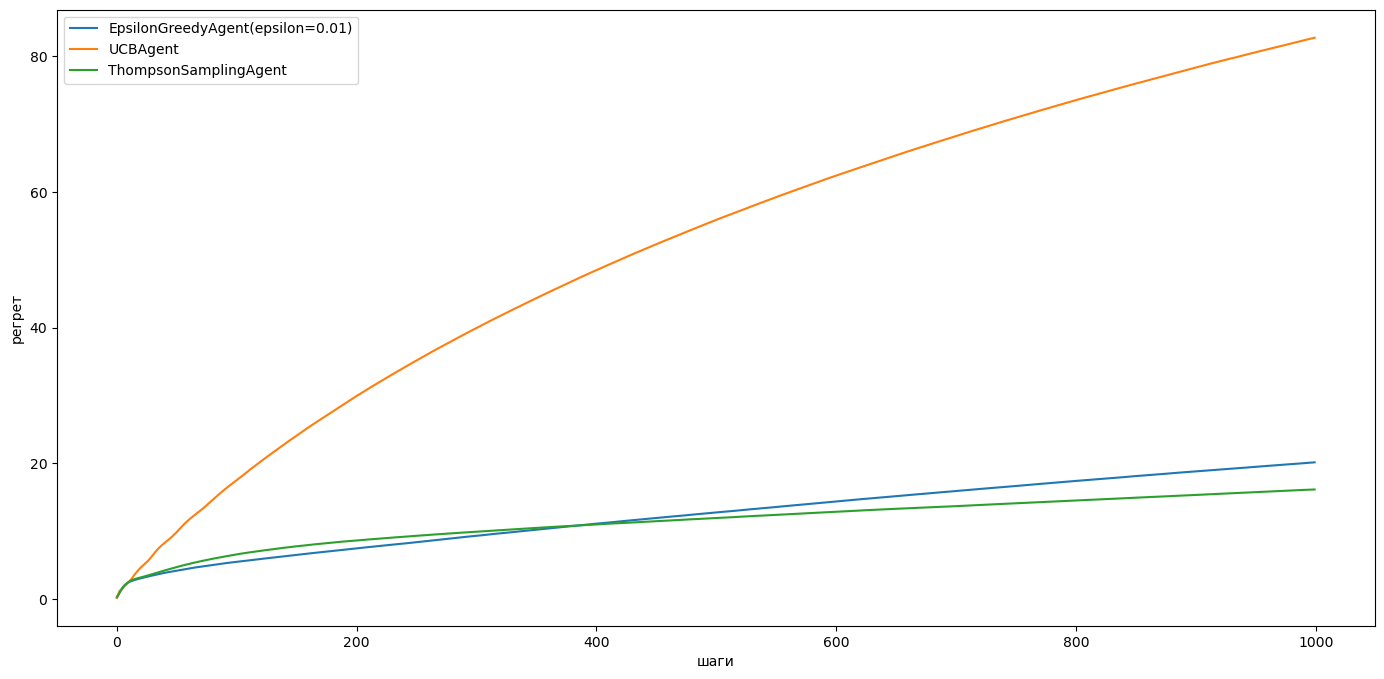

CPU times: user 4min, sys: 486 ms, total: 4min
Wall time: 4min


In [16]:
%%time
np.random.seed(SEED)


agents = [
     EpsilonGreedyAgent(),
     UCBAgent(),
     ThompsonSamplingAgent()
]

plot_regret(BernoulliBandit(), agents, n_steps=1000, n_trials=10000)

# Нестационарные бандиты

Но что в случае изменяющихся со временем вероятностей? Например:

In [17]:
class DriftingBandit(BernoulliBandit):
    def __init__(self, n_actions=5, gamma=.01):
        """
        Идея взята из https://github.com/iosband/ts_tutorial
        """
        super().__init__(n_actions)
        
        self._gamma = gamma
        
        self._successes = None
        self._failures = None
        self._steps = 0
        
        self.reset()
        
    def reset(self):
        self._successes = np.zeros(self.action_count) + 1.
        self._failures = np.zeros(self.action_count) + 1.
        self._steps = 0
    
    def step(self):
        action = np.random.randint(self.action_count)
        reward = self.pull(action)
        self._step(action, reward)
        
    def _step(self, action, reward): 
        self._successes = self._successes * (1. - self._gamma) + self._gamma
        self._failures = self._failures * (1. - self._gamma) + self._gamma
        self._steps += 1

        self._successes[action] += reward
        self._failures[action] += 1 - reward

        self._probs = np.random.beta(self._successes, self._failures)

Обратите внимание на вероятности наград, изменяющиеся со временем:

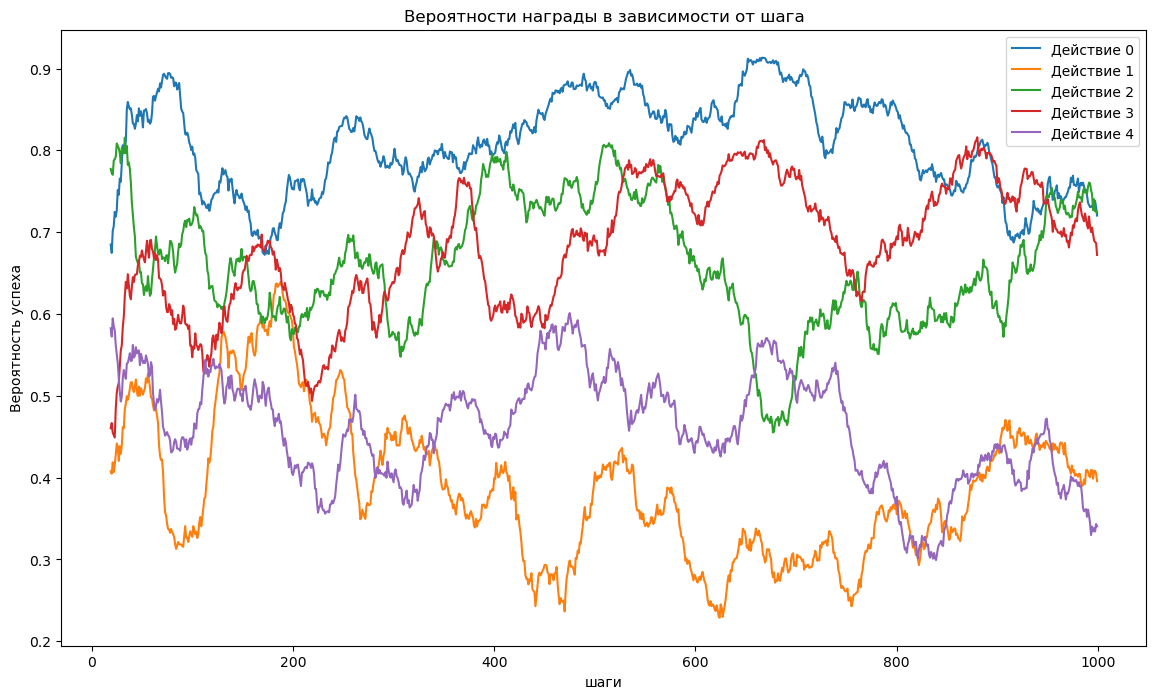

CPU times: user 167 ms, sys: 27 µs, total: 167 ms
Wall time: 165 ms


In [18]:
%%time
np.random.seed(SEED)


drifting_env = DriftingBandit(n_actions=5)

drifting_probs = []
for i in range(1000):
    drifting_env.step()
    drifting_probs.append(drifting_env._probs)

plt.figure(figsize=(14, 8))
plt.plot(pd.DataFrame(drifting_probs).rolling(window=20).mean())

plt.xlabel("шаги")
plt.ylabel("Вероятность успеха")
plt.title("Вероятности награды в зависимости от шага")
plt.legend(["Действие {}".format(i) for i in range(drifting_env.action_count)])
plt.show()

**Задача** &mdash; создать агента, который будет работать лучше каждой рассмотренной выше стационарной стратегии.

Мой агент -- модифицированный Thompson Sampling: перед добавлением награды число успехов и провалов умножается на `(1 - self._gamma)`, т.к. старые вероятности со временем теряют свою актуальность

In [41]:
class YourAgent(AbstractAgent):
    def __init__(self, gamma=.01):
        self._gamma = gamma
    
    def get_action(self):
        beta_sample = np.random.beta(self._successes + DELTA, self._failures + DELTA)
        return np.argmax(beta_sample)
    
    def update(self, action, reward):
        """
        Учёт полученной награды в результате совершённого действия и обновление внутренних параметров агента
        :тип данных action: int
        :тип данных reward: int
        """
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] *= (1 - self._gamma)
            self._successes[action] += reward
        else:
            self._failures[action] *= (1 - self._gamma)
            self._failures[action] += reward

/tmp/ipykernel_89387/3860867694.py:4: RuntimeWarning: divide by zero encountered in log
  expected_values += np.sqrt(2 * np.log(self._total_pulls) / (self._successes + self._failures + DELTA))
/tmp/ipykernel_89387/3860867694.py:4: RuntimeWarning: invalid value encountered in sqrt
  expected_values += np.sqrt(2 * np.log(self._total_pulls) / (self._successes + self._failures + DELTA))


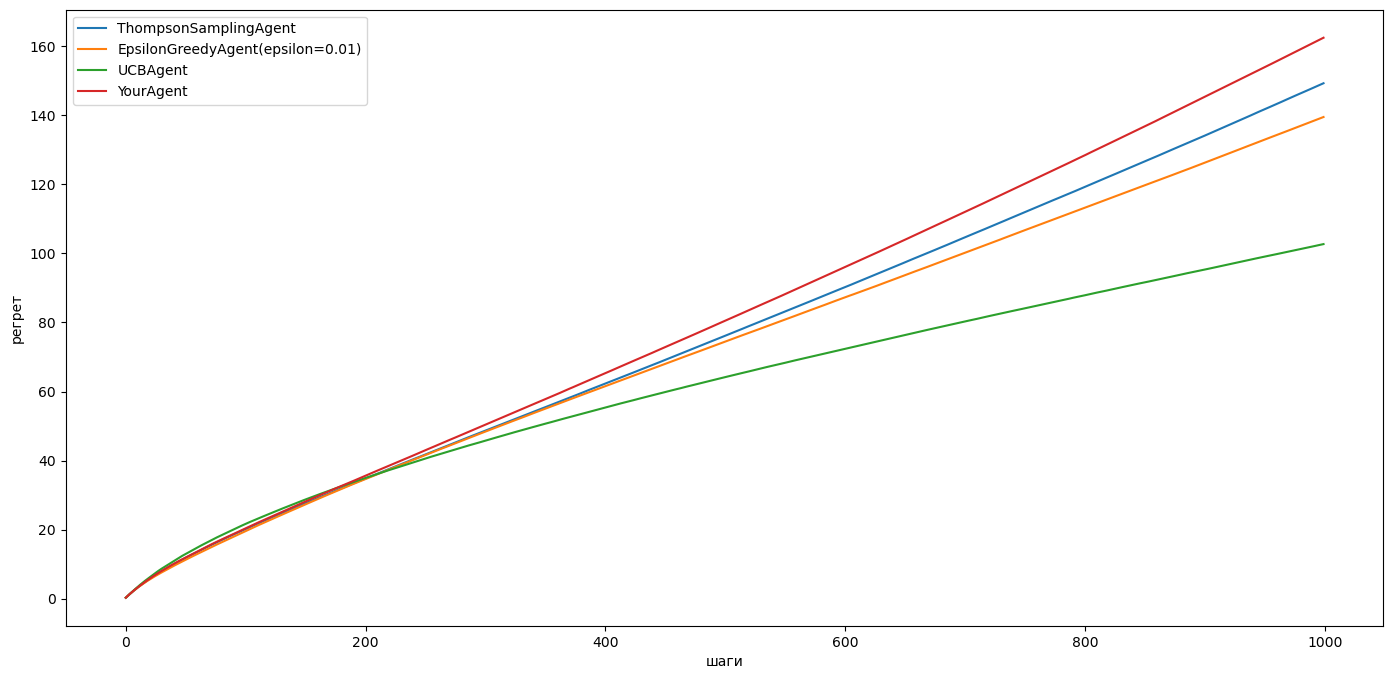

CPU times: user 7min 54s, sys: 460 ms, total: 7min 54s
Wall time: 7min 54s


In [28]:
%%time
np.random.seed(SEED)


drifting_agents = [
    ThompsonSamplingAgent(),
    EpsilonGreedyAgent(),
    UCBAgent(),
    YourAgent()
]

plot_regret(DriftingBandit(), drifting_agents, n_steps=1000, n_trials=10000)

## Исследование среды в MDP

Следующая задача, "river flow", демонстрирует важность исследования среды на примере Марковского процесса принятия решений.

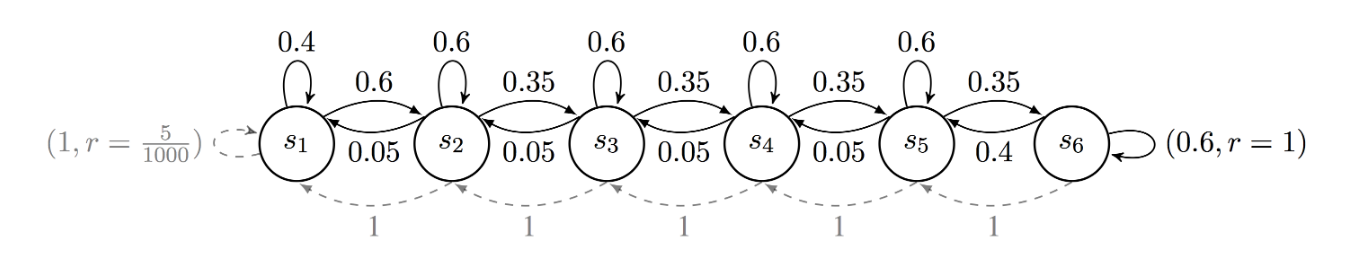

Рисунок взят из https://arxiv.org/abs/1306.0940

Награды и вероятности переходов агенту не известны.

Оптимальная стратегия состоит в том, чтобы идти направо против потока, тогда как легче будет идти налево и получать небольшую награду каждый раз.

In [29]:
class RiverSwimEnv:
    LEFT_REWARD = 5. / 1000
    RIGHT_REWARD = 1.
    
    def __init__(self, intermediate_states_count=4, max_steps=16):
        self._max_steps = max_steps
        self._current_state = None
        self._steps = None
        self._interm_states = intermediate_states_count
        self.reset()
        
    def reset(self):
        self._steps = 0
        self._current_state = 1
        return self._current_state, 0., False
        
    @property
    def n_actions(self):
        return 2
    
    @property
    def n_states(self):
        return 2 + self._interm_states
    
    def _get_transition_probs(self, action):
        if action == 0:
            if self._current_state == 0:
                return [.0, 1., .0]
            else:
                return [1., .0, .0]
            
        elif action == 1:
            if self._current_state == 0:
                return [.0, .4, .6]
            if self._current_state == self.n_states - 1:
                return [.4, .6, .0]
            else:
                return [.05, .6, .35]
        else:
            raise RuntumeError("Неизвестное действие {}. Максимальное количество действий {}".format(
                action, self.n_actions))

    def step(self, action):
        """
        :параметр action:
        :тип данных action: int
        :возвращает: observation, reward, is_done
        :тип возвращаемых данных: (int, float, bool)
        """
        reward = 0.
        
        if self._steps >= self._max_steps:
            return self._current_state, reward, True
        
        transition = np.random.choice(range(3), p=self._get_transition_probs(action))
        if transition == 0:
            self._current_state -= 1
        elif transition == 1:
            pass
        else:
            self._current_state += 1
        
        if self._current_state == 0:
            reward = self.LEFT_REWARD
        elif self._current_state == self.n_states - 1:
            reward = self.RIGHT_REWARD
        
        self._steps += 1
        return self._current_state, reward, False

Ниже предлагается реализовать Q-обучение агента с $\varepsilon$-жадной стратегией и посмотреть на производительность данного решения.

In [30]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, lr=.2, gamma=.95, epsilon=.1):
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n_states, n_actions))
        self._lr = lr

    def get_action(self, state):
        if np.random.random() < self._epsilon:
            return np.random.randint(0, self._q_matrix.shape[1])
        else:
            return np.argmax(self._q_matrix[state])
    
    def get_q_matrix(self):
        """ Используется для визуализации политики
        """
        
        return self._q_matrix
        
    def start_episode(self):
        """ Используется в PSRL агенте
        """
        pass

    def update(self, state, action, reward, next_state):
        update_step = reward + self._gamma * np.max(self._q_matrix[next_state])
        update_step -= self._q_matrix[state, action]

        self._q_matrix[state, action] += self._lr * update_step

In [31]:
def train_mdp_agent(agent, env, n_episodes):
    episode_rewards = []
    
    for ep in range(n_episodes):
        state, ep_reward, is_done = env.reset()
        agent.start_episode()
        while not is_done:
            action = agent.get_action(state)
            
            next_state, reward, is_done = env.step(action)
            agent.update(state, action, reward, next_state)
            
            state = next_state
            ep_reward += reward
            
        episode_rewards.append(ep_reward)
    return episode_rewards

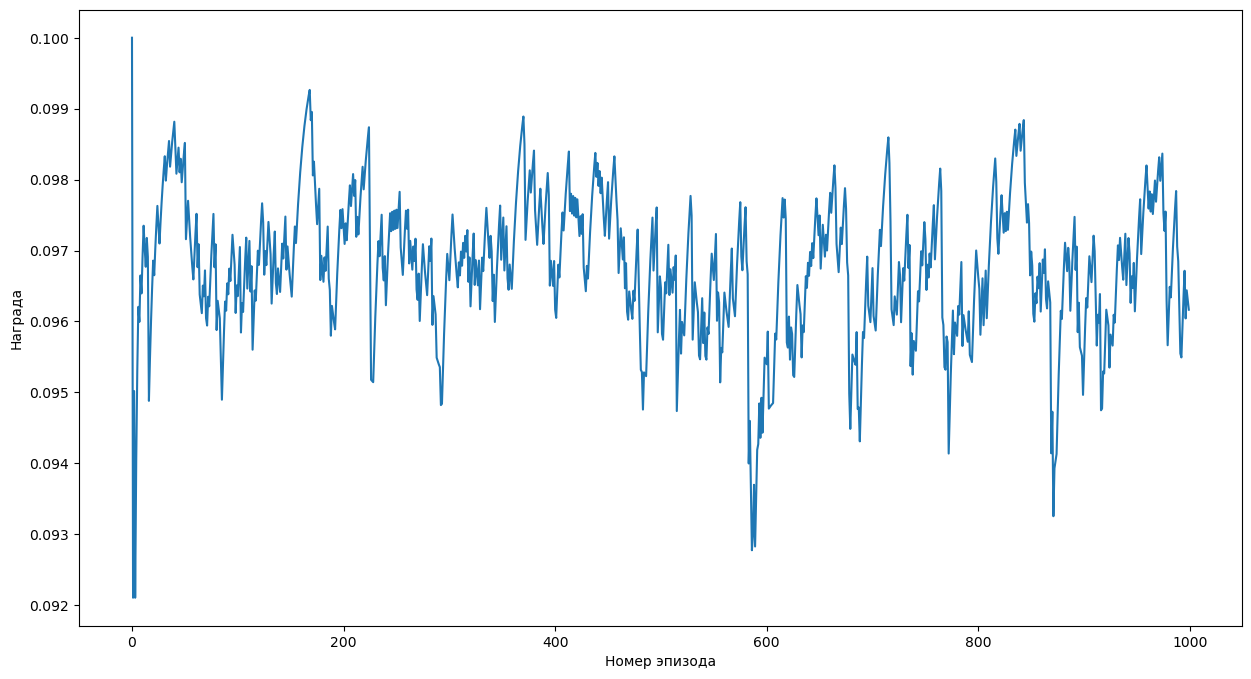

CPU times: user 371 ms, sys: 112 ms, total: 483 ms
Wall time: 395 ms


In [32]:
%%time
np.random.seed(SEED)


horizon = 20
env = RiverSwimEnv(max_steps=horizon)
agent = QLearningAgent(env.n_states, env.n_actions)
rews = train_mdp_agent(agent, env, 1000)
plt.figure(figsize=(15, 8))

plt.plot(pd.DataFrame.ewm(pd.DataFrame(np.array(rews)), alpha=.1).mean())
plt.xlabel("Номер эпизода")
plt.ylabel("Награда")
plt.show()

Ниже реализована визуализация решений агента:

In [33]:
def plot_policy(agent):
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    im = ax.matshow(agent.get_q_matrix().T)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['лево', 'право'])
    fig.colorbar(im, orientation='horizontal')
    plt.xlabel("Состояние")
    plt.ylabel("Действие")
    plt.title("Значения Q-функции ценности")
    plt.show()

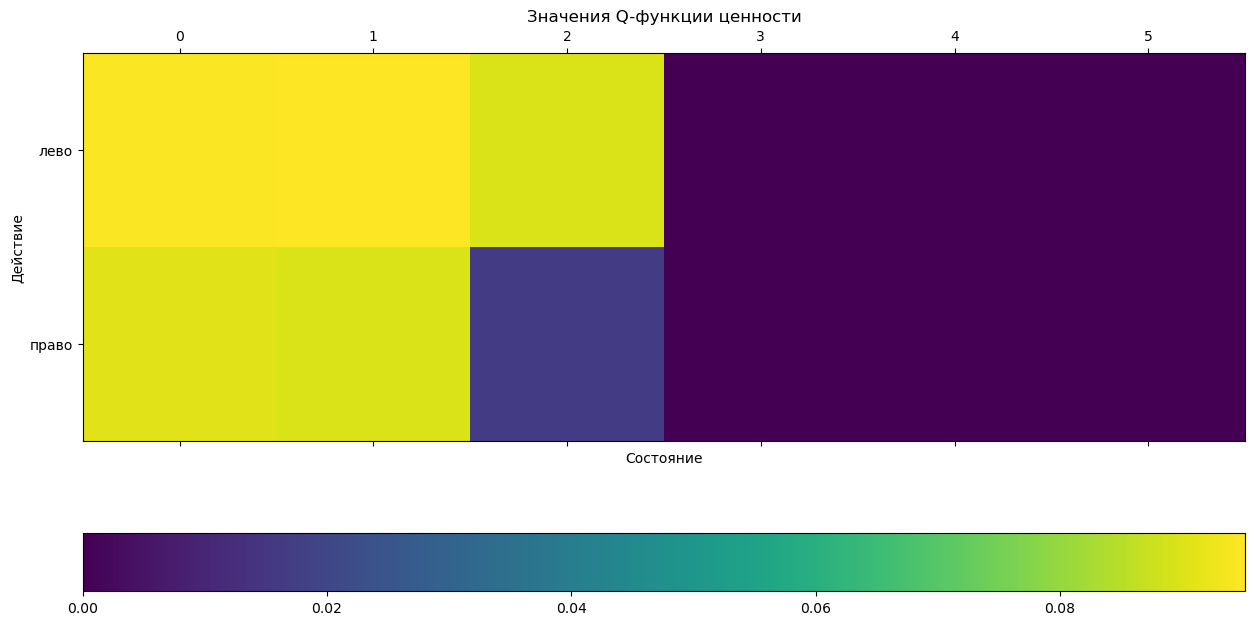

In [34]:
plot_policy(agent)

Видно, что агент использует неоптимальную стратегию и продолжает идти налево, не зная про вариант получше.

## Posterior sampling RL

Настало время реализовать сэмплирование по Томпсону для MDP!

Алгоритм:

>**for** эпизода $k = 1,2,...$ **do**
>> сэмплировать $M_k \sim f(\bullet\ |\ H)$ из апостериорного распределения, $M_k$ &mdash; MDP, $H$ &mdash; траектория взаимодействия со средой, собираемая совокупно со всех эпизодов

>> Вычислить политику $\mu_k$ для $M_k$ с помощью Value Iteration

>> **for** шагов $t = 1, 2,...$ **do**

>>> выбрать действие  $a_t^k$ из $\mu_k$ будучи в состоянии $s_t^k$

>>> получить $r_t^k$ и $s_{t+1}^k$ ($r_t^k$ &mdash; награда за $a_t^k$, $s_{t + 1}^k$ &mdash; следующее состояние)

>>> обновить $H$ с помощью $(s_t^k, a_t^k, r_t^k, s_{t + 1}^k)$

>> **end for**

>**end for**

Марковский процесс принятия решений $M_k$ представлен двумя матрицами: вероятности переходов и награды. Обратите внимание, что тут фактор дисконтирования принимается равным 1, а длина эпизода ограничена. Матрица переходов сэмплируется из распределения Дирихле, в то время как матрица наград сэмплируется из гамма-нормального распределения.

Распределения обновляются согласно правилу Байеса (см. https://en.wikipedia.org/wiki/Conjugate_prior для непрерывных распределений).

Дополнительные материалы &mdash; https://arxiv.org/abs/1306.0940.

In [38]:
def sample_normal_gamma(mu, lmbd, alpha, beta):
    """
    https://en.wikipedia.org/wiki/Normal-gamma_distribution
    https://numpy.org/doc/stable/reference/random/generated/numpy.random.gamma.html
    """
    k = alpha
    theta = beta
    tau = np.random.gamma(k, theta)
    norm = np.random.normal(mu, 1.0 / np.sqrt(lmbd * tau))
    return norm, tau


class PsrlAgent:
    def __init__(self, n_states, n_actions, horizon=10):
        self._n_states = n_states
        self._n_actions = n_actions
        self._horizon = horizon
        
        # параметры для сэмплирования матрицы переходов --- распределение Дирихле
        self._transition_counts = np.zeros((n_states, n_states, n_actions)) + 1.
        
        # параметры для сэмплирования наград --- гамма-нормальное распределение
        self._mu_matrix = np.zeros((n_states, n_actions)) + 1.
        self._state_action_counts = np.zeros((n_states, n_actions)) + 1.  # lambda
        
        self._alpha_matrix = np.zeros((n_states, n_actions)) + 1.
        self._beta_matrix = np.zeros((n_states, n_actions)) + 1.
        
        self._current_value_function = np.zeros(n_states)
        
    def _value_iteration(self, transitions, rewards):
        state_values = np.max(rewards +
                         self._current_value_function.dot(transitions), axis = 1)
        return state_values
        
    def start_episode(self):
        # сэмпл нового Марковского процесса принятия решений
        self._sampled_transitions = np.apply_along_axis(np.random.dirichlet, 1, self._transition_counts)
        
        sampled_reward_mus, sampled_reward_stds = sample_normal_gamma(
            self._mu_matrix,
            self._state_action_counts,
            self._alpha_matrix,
            self._beta_matrix
        )
        

        self._sampled_rewards = sampled_reward_mus
        self._current_value_function = self._value_iteration(self._sampled_transitions, self._sampled_rewards)

    def get_action(self, state):
        return np.argmax(self._sampled_rewards[state] + 
                         self._current_value_function.dot(self._sampled_transitions[state]))

    def update(self, state, action, reward, next_state):
        # update rules:
        # https://en.wikipedia.org/wiki/Normal-gamma_distribution#Posterior_distribution_of_the_parameters
        # https://en.wikipedia.org/wiki/Dirichlet_distribution
        self._transition_counts[state, next_state, action] += 1

        mu_0 = self._mu_matrix[state, action]
        lambda_0 = self._state_action_counts[state, action]
        alpha_0 = self._alpha_matrix[state, action]
        beta_0 = self._beta_matrix[state, action]

        new_mu = (lambda_0 * mu_0 + reward) / (lambda_0 + 1)
        new_lambda = lambda_0 + 1
        new_alpha = alpha_0 + 0.5
        new_beta = beta_0 + 0.5 * lambda_0 * (reward - mu_0)**2 / (lambda_0 + 1)

        self._mu_matrix[state, action] = new_mu
        self._state_action_counts[state, action] = new_lambda
        self._alpha_matrix[state, action] = new_alpha
        self._beta_matrix[state, action] = new_beta
        
    def get_q_matrix(self):
        return self._sampled_rewards + self._current_value_function.dot(self._sampled_transitions)
        

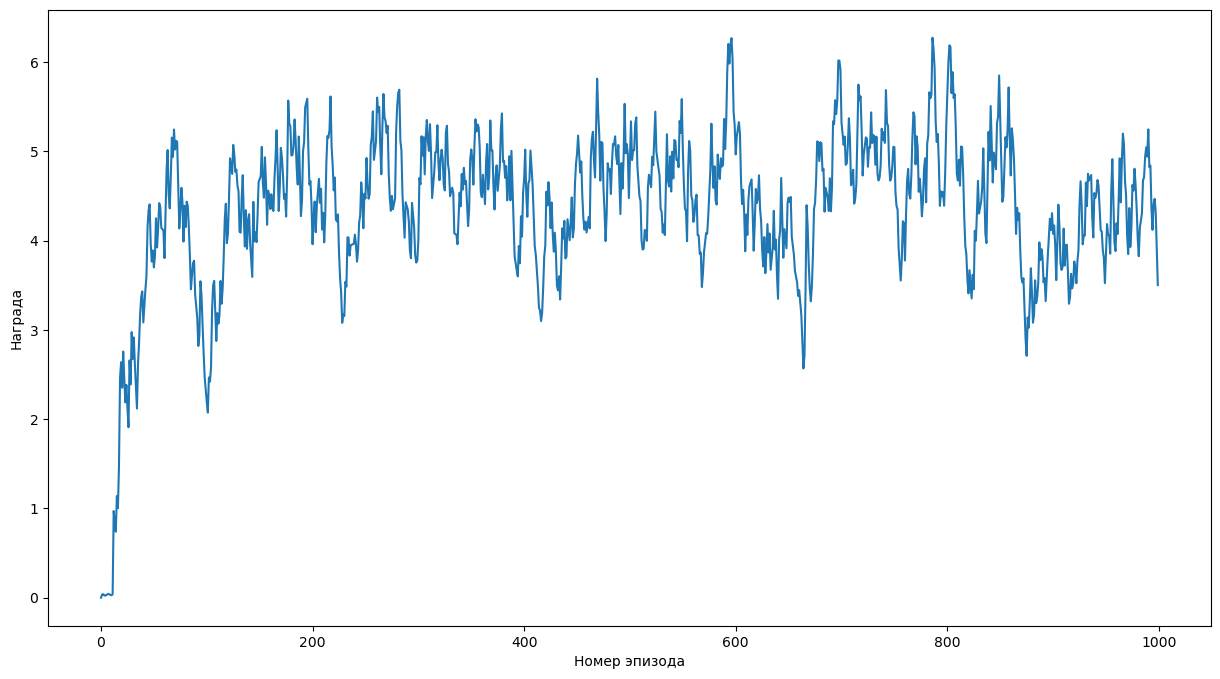

CPU times: user 483 ms, sys: 7.99 ms, total: 491 ms
Wall time: 490 ms


In [39]:
%%time
np.random.seed(SEED)


horizon = 20
env = RiverSwimEnv(max_steps=horizon)
agent = PsrlAgent(env.n_states, env.n_actions, horizon=horizon)
rews = train_mdp_agent(agent, env, 1000)

plt.figure(figsize=(15, 8))
plt.plot(pd.DataFrame.ewm(pd.DataFrame(np.array(rews)), alpha=.1).mean())
plt.xlabel("Номер эпизода")
plt.ylabel("Награда")
plt.show()

Вот теперь другое дело:

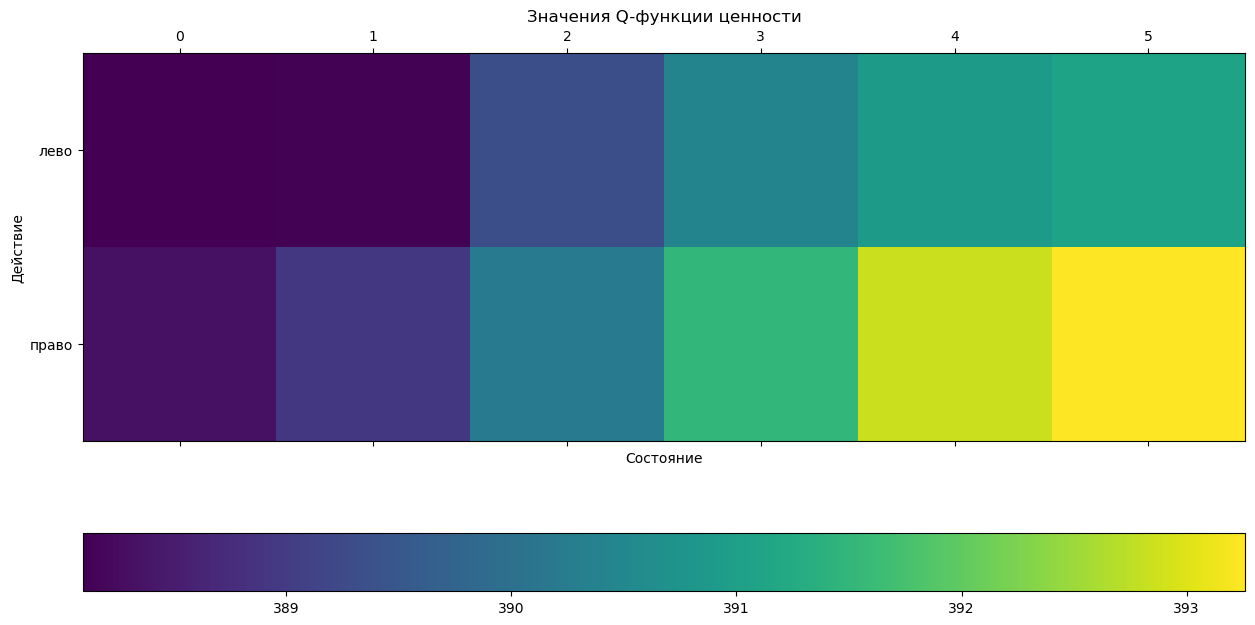

In [40]:
plot_policy(agent)